### Data handling

In [1]:
!rm -rf /kaggle/working/cityscapes
!mkdir -p /kaggle/working/cityscapes/leftImg8bit/train
!mkdir -p /kaggle/working/cityscapes/gtFine/train
!mkdir -p /kaggle/working/cityscapes/leftImg8bit/val
!mkdir -p /kaggle/working/cityscapes/gtFine/val

!cp -r /kaggle/input/cityscapes/leftImg8bit_trainvaltest/leftImg8bit/train/aachen /kaggle/working/cityscapes/leftImg8bit/train/
!cp -r /kaggle/input/cityscapes/gtFine_trainvaltest/gtFine/train/aachen /kaggle/working/cityscapes/gtFine/train/
!cp -r /kaggle/input/cityscapes/leftImg8bit_trainvaltest/leftImg8bit/train/bremen /kaggle/working/cityscapes/leftImg8bit/train/
!cp -r /kaggle/input/cityscapes/gtFine_trainvaltest/gtFine/train/bremen /kaggle/working/cityscapes/gtFine/train/
!cp -r /kaggle/input/cityscapes/leftImg8bit_trainvaltest/leftImg8bit/train/hamburg /kaggle/working/cityscapes/leftImg8bit/train/
!cp -r /kaggle/input/cityscapes/gtFine_trainvaltest/gtFine/train/hamburg /kaggle/working/cityscapes/gtFine/train/
!cp -r /kaggle/input/cityscapes/leftImg8bit_trainvaltest/leftImg8bit/train/strasbourg /kaggle/working/cityscapes/leftImg8bit/train/
!cp -r /kaggle/input/cityscapes/gtFine_trainvaltest/gtFine/train/strasbourg /kaggle/working/cityscapes/gtFine/train/
!cp -r /kaggle/input/cityscapes/leftImg8bit_trainvaltest/leftImg8bit/train/stuttgart /kaggle/working/cityscapes/leftImg8bit/train/
!cp -r /kaggle/input/cityscapes/gtFine_trainvaltest/gtFine/train/stuttgart /kaggle/working/cityscapes/gtFine/train/

# Sao chép toàn bộ tập validation
!cp -r /kaggle/input/cityscapes/leftImg8bit_trainvaltest/leftImg8bit/val/* /kaggle/working/cityscapes/leftImg8bit/val/
!cp -r /kaggle/input/cityscapes/gtFine_trainvaltest/gtFine/val/* /kaggle/working/cityscapes/gtFine/val/
print("Cityscapes data copied to /kaggle/working/cityscapes")


Cityscapes data copied to /kaggle/working/cityscapes


In [2]:
!pip install -q pycocotools

In [3]:
import os
import json
from PIL import Image
from tqdm import tqdm

def create_cityscapes_coco_json(data_root, set_type='val', output_file='cityscapes_val_coco_format.json'):
    img_dir = os.path.join(data_root, 'leftImg8bit', set_type)
    ann_dir = os.path.join(data_root, 'gtFine', set_type)
    
    CITYSCAPES_CLASSES = [
        'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle',
        'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
        'traffic sign', 'vegetation', 'terrain', 'sky'
    ]

    def cityscapes_class_to_id(class_name):
        try:
            return CITYSCAPES_CLASSES.index(class_name) + 1
        except ValueError:
            return 0

    print(f"Starting conversion for '{set_type}' set...")

    coco_output = {
        "images": [],
        "annotations": [],
        "categories": []
    }

    for i, class_name in enumerate(CITYSCAPES_CLASSES):
        coco_output["categories"].append({
            "id": i + 1,
            "name": class_name,
            "supercategory": "object"
        })

    image_id_counter = 1
    annotation_id_counter = 1

    for city in tqdm(sorted(os.listdir(img_dir)), desc="Processing cities"):
        city_img_path = os.path.join(img_dir, city)
        city_ann_path = os.path.join(ann_dir, city)
        
        if not os.path.isdir(city_img_path):
            continue

        for img_file in sorted(os.listdir(city_img_path)):
            if not img_file.endswith('_leftImg8bit.png'):
                continue
            
            img_path = os.path.join(city_img_path, img_file)
            with Image.open(img_path) as img:
                width, height = img.size
            
            image_info = {
                "id": image_id_counter,
                "width": width,
                "height": height,
                "file_name": os.path.join(city, img_file)
            }
            coco_output["images"].append(image_info)
            
            ann_file = img_file.replace('_leftImg8bit.png', '_gtFine_polygons.json')
            ann_path = os.path.join(city_ann_path, ann_file)
            
            if not os.path.exists(ann_path):
                image_id_counter += 1
                continue

            with open(ann_path, 'r') as f:
                ann_data = json.load(f)
                
            for obj in ann_data.get('objects', []):
                category_id = cityscapes_class_to_id(obj.get('label'))
                if category_id == 0:
                    continue
                    
                poly = obj.get('polygon')
                if not poly or len(poly) < 3:
                    continue
                
                poly_flat = [coord for point in poly for coord in point]
                x_coords = poly_flat[0::2]
                y_coords = poly_flat[1::2]
                x_min, y_min = min(x_coords), min(y_coords)
                x_max, y_max = max(x_coords), max(y_coords)
                
                bbox = [x_min, y_min, x_max - x_min, y_max - y_min]
                area = bbox[2] * bbox[3]

                annotation_info = {
                    "id": annotation_id_counter,
                    "image_id": image_id_counter,
                    "category_id": category_id,
                    "segmentation": [poly_flat],
                    "area": float(area),
                    "bbox": [float(b) for b in bbox],
                    "iscrowd": 0
                }
                coco_output["annotations"].append(annotation_info)
                annotation_id_counter += 1
            
            image_id_counter += 1

    output_path = os.path.join(data_root, output_file)
    with open(output_path, 'w') as f:
        json.dump(coco_output, f)
        
    print(f"\nConversion complete!")
    print(f"Total images: {len(coco_output['images'])}")
    print(f"Total annotations: {len(coco_output['annotations'])}")
    print(f"COCO format JSON file saved to: {output_path}")

In [4]:
DATA_ROOT = "/kaggle/working/cityscapes"
create_cityscapes_coco_json(data_root=DATA_ROOT, set_type='val', output_file='cityscapes_val_coco_format.json')
print("Ready to set sail! Sire.")

Starting conversion for 'val' set...


Processing cities: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]



Conversion complete!
Total images: 500
Total annotations: 33207
COCO format JSON file saved to: /kaggle/working/cityscapes/cityscapes_val_coco_format.json
Ready to set sail! Sire.


### Main pipeline

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import GradScaler, autocast

import torchvision
from torchvision.transforms import ToTensor, Compose, RandomHorizontalFlip, Resize, Normalize
from torchvision.transforms import functional as TF
from torchvision.ops import roi_align, nms
from torchvision.models import resnet50

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from torchvision.ops import box_iou
import pycocotools.mask as mask_util

import matplotlib.pyplot as plt

import numpy as np
import math
from PIL import Image, ImageDraw
import os
import json
import random
from tqdm import tqdm
from torchvision.ops import box_iou
from torchvision.ops import batched_nms

In [6]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

### Prepare data

In [7]:
CITYSCAPES_CLASSES = [
    'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle',
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky'
]
NUM_CLASSES = len(CITYSCAPES_CLASSES) + 1

In [8]:
def cityscapes_class_to_id(class_name):
    try:
        return CITYSCAPES_CLASSES.index(class_name) + 1
    except ValueError:
        return 0

In [9]:
class CityscapesMaskRCNNDataset(Dataset):
    def __init__(self, root_dir, set_type='train', image_size=(800, 800)):
        self.root_dir = root_dir
        self.set_type = set_type
        self.img_dir = os.path.join(root_dir, 'leftImg8bit', set_type)
        self.ann_dir = os.path.join(root_dir, 'gtFine', set_type)
        self.image_size = image_size

        self.transforms = Compose([
            Resize(self.image_size),
            ToTensor(),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        self.img_paths = []
        self.ann_paths = []
        for city in sorted(os.listdir(self.img_dir)):
            city_img_path = os.path.join(self.img_dir, city)
            city_ann_path = os.path.join(self.ann_dir, city)
            for img_file in sorted(os.listdir(city_img_path)):
                if img_file.endswith('_leftImg8bit.png'):
                    img_path = os.path.join(city_img_path, img_file)
                    ann_file = img_file.replace('_leftImg8bit.png', '_gtFine_polygons.json')
                    ann_path = os.path.join(city_ann_path, ann_file)
                    if os.path.exists(ann_path):
                        self.img_paths.append(img_path)
                        self.ann_paths.append(ann_path)

        print(f"Loaded {len(self.img_paths)} {set_type} images")

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        ann_path = self.ann_paths[index]

        img = Image.open(img_path).convert("RGB")
        original_w, original_h = img.size

        with open(ann_path, 'r') as f:
            ann = json.load(f)

        boxes = []
        labels = []
        masks_polygons = []

        for obj in ann.get('objects', []):
            label_id = cityscapes_class_to_id(obj.get('label'))
            if label_id == 0: continue
            poly = obj.get('polygon')
            if not poly or len(poly) < 3: continue
            
            poly_flat = [coord for point in poly for coord in point]
            x_coords, y_coords = poly_flat[0::2], poly_flat[1::2]
            x1, y1 = min(x_coords), min(y_coords)
            x2, y2 = max(x_coords), max(y_coords)

            if x2 <= x1 or y2 <= y1: continue

            boxes.append([x1, y1, x2, y2])
            labels.append(label_id)
            masks_polygons.append(poly)

        if not boxes:
            return self.__getitem__(random.randint(0, len(self) - 1))

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        
        masks = []
        for poly in masks_polygons:
            mask = Image.new('L', (original_w, original_h), 0)
            ImageDraw.Draw(mask).polygon([tuple(p) for p in poly], outline=1, fill=1)
            masks.append(np.array(mask))
        masks = torch.from_numpy(np.array(masks)).float()

        if self.set_type == 'train' and random.random() > 0.5:
            img = TF.hflip(img)
            masks = TF.hflip(masks)
            boxes[:, [0, 2]] = original_w - boxes[:, [2, 0]]

        img_tensor = self.transforms(img)
        h, w = self.image_size
        
        masks = TF.resize(masks, [28, 28], interpolation=TF.InterpolationMode.NEAREST)
        
        boxes[:, [0, 2]] *= (w / original_w)
        boxes[:, [1, 3]] *= (h / original_h)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': torch.tensor([index + 1]) 
        }

        return {'image': img_tensor, 'target': target}

In [10]:
def collate_fn(batch):
    batch = [item for item in batch if item is not None]
    if not batch:
        return None, None
    images = [item['image'] for item in batch]
    targets = [item['target'] for item in batch]
    
    return images, targets

### Backbone Resnet50 + FPN

In [11]:
class ResNetBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = resnet50(weights='IMAGENET1K_V2')
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        c1 = self.maxpool(x)
        c2 = self.layer1(c1)
        c3 = self.layer2(c2)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)
        return [c2, c3, c4, c5]

In [12]:
class FPN(nn.Module):
    def __init__(self, in_channels_list=[256, 512, 1024, 2048], out_channels=256):
        super().__init__()
        self.lateral_convs = nn.ModuleList([
            nn.Conv2d(in_c, out_channels, 1) for in_c in in_channels_list
        ])
        self.output_convs = nn.ModuleList([
            nn.Conv2d(out_channels, out_channels, 3, padding=1) for _ in in_channels_list
        ])

    def forward(self, c2, c3, c4, c5):
        p5 = self.lateral_convs[3](c5)
        p4 = self.lateral_convs[2](c4) + F.interpolate(p5, size=c4.shape[-2:], mode='nearest')
        p3 = self.lateral_convs[1](c3) + F.interpolate(p4, size=c3.shape[-2:], mode='nearest')
        p2 = self.lateral_convs[0](c2) + F.interpolate(p3, size=c2.shape[-2:], mode='nearest')
        return [self.output_convs[i](p) for i, p in enumerate([p2, p3, p4, p5])]

### Region proposal network

In [13]:
class RPN(nn.Module):
    def __init__(self, in_channels=256, num_anchors=3):
        super(RPN, self).__init__()
        self.num_anchors = num_anchors
        self.conv = nn.Conv2d(in_channels, 512, kernel_size=3, padding=1)
        self.cls = nn.Conv2d(512, num_anchors, kernel_size=1)
        self.reg = nn.Conv2d(512, 4 * num_anchors, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv(x))
        scores = self.cls(x)
        deltas = self.reg(x)
        return scores, deltas

In [14]:
class MaskHead(nn.Module):
    def __init__(self, in_channels=256, num_classes=81):
        super().__init__()
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(in_channels, 256, 3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU()
        )
        self.deconv = nn.ConvTranspose2d(256, 256, 2, stride=2)
        self.mask_pred = nn.Conv2d(256, num_classes, 1)

    def forward(self, x):
        x = self.conv_blocks(x)
        x = self.deconv(x)
        return self.mask_pred(x)

### Main mask rcnn

In [15]:
class MaskRCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # --- 1. Các thành phần của mô hình ---
        self.backbone = ResNetBackbone()
        self.fpn = FPN()
        self.rpn = RPN(in_channels=256, num_anchors=3)
        
        self.box_roi_pool = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=7, sampling_ratio=2)
        self.mask_roi_pool = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=14, sampling_ratio=2)

        resolution = self.box_roi_pool.output_size[0]
        representation_size = 256 * resolution * resolution
        
        # Các lớp head
        self.box_head = nn.Sequential(nn.Linear(representation_size, 1024), nn.ReLU())
        self.cls_score = nn.Linear(1024, num_classes)
        self.box_predictor = nn.Linear(1024, num_classes * 4)
        
        self.mask_head = MaskHead(in_channels=256, num_classes=num_classes)
        
        # --- 2. Khởi tạo trọng số cho các lớp head mới ---
        # Đây là bước quan trọng để ổn định quá trình training.
        print("Initializing weights for new layers...")
        for layer in self.box_head.modules():
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, std=0.01)
                nn.init.constant_(layer.bias, 0)
        
        nn.init.normal_(self.cls_score.weight, std=0.01)
        nn.init.constant_(self.cls_score.bias, 0)
        
        # Lớp regression thường cần std nhỏ hơn
        nn.init.normal_(self.box_predictor.weight, std=0.001)
        nn.init.constant_(self.box_predictor.bias, 0)

        # --- 3. Các siêu tham số cho inference ---
        self.num_classes = num_classes
        self.score_thresh = 0.05
        self.nms_thresh = 0.5
        self.detections_per_img = 100

    def forward(self, images, targets=None):
        if self.training and targets is None:
            raise ValueError("In training mode, targets should be passed")

        original_image_sizes = [img.shape[-2:] for img in images]
        image_batch = torch.stack(images, dim=0)
        
        # --- Backbone + FPN ---
        c2, c3, c4, c5 = self.backbone(image_batch)
        fpn_features_list = self.fpn(c2, c3, c4, c5)
        features = {f'{i}': fpn_features_list[i] for i in range(4)}

        # --- RPN ---
        anchors = generate_pyramid_anchors([feat.shape[-2:] for feat in fpn_features_list], [4, 8, 16, 32], [32, 64, 128, 256], device=image_batch.device)
        
        rpn_cls_logits_list, rpn_box_deltas_list = [], []
        for feat in fpn_features_list:
            cls_logits, box_deltas = self.rpn(feat)
            B, _, H, W = cls_logits.shape
            cls_logits = cls_logits.permute(0, 2, 3, 1).reshape(B, -1)
            box_deltas = box_deltas.permute(0, 2, 3, 1).reshape(B, -1, 4)
            rpn_cls_logits_list.append(cls_logits)
            rpn_box_deltas_list.append(box_deltas)

        rpn_cls_logits = torch.cat(rpn_cls_logits_list, dim=1)
        rpn_box_deltas = torch.cat(rpn_box_deltas_list, dim=1)

        proposals = []
        for i in range(image_batch.shape[0]):
            decoded_boxes = decode_boxes(anchors, rpn_box_deltas[i])
            single_image_proposals = generate_proposals(torch.sigmoid(rpn_cls_logits[i]), decoded_boxes, original_image_sizes[i])
            proposals.append(single_image_proposals)

        # --- RoI Heads (Training or Inference) ---
        if self.training:
            # --- Training Logic ---
            assigned_gt_idxs, labels = self.assign_targets_to_proposals(proposals, targets)
            sampled_idxs_list = [sample_rois(lbl) for lbl in labels]
            
            proposals_sampled = [p[s] for p, s in zip(proposals, sampled_idxs_list)]
            labels_sampled = [l[s] for l, s in zip(labels, sampled_idxs_list)]
            assigned_gt_idxs_sampled = [g[s] for g, s in zip(assigned_gt_idxs, sampled_idxs_list)]

            box_features = self.box_roi_pool(features, proposals_sampled, original_image_sizes)
            box_head_output = self.box_head(box_features.flatten(start_dim=1))
            class_logits = self.cls_score(box_head_output)
            box_regression = self.box_predictor(box_head_output)
            
            return compute_losses(class_logits, box_regression, proposals_sampled, labels_sampled, assigned_gt_idxs_sampled, targets)

        else: # Inference
            box_features = self.box_roi_pool(features, proposals, original_image_sizes)
            box_head_output = self.box_head(box_features.flatten(start_dim=1))
            class_logits = self.cls_score(box_head_output)
            box_regression = self.box_predictor(box_head_output)
            
            detections = self.postprocess_detections(class_logits, box_regression, proposals, original_image_sizes)
            return detections

    def assign_targets_to_proposals(self, proposals, targets):
        all_assigned_gt_idxs, all_labels = [], []
        for i in range(len(proposals)):
            gt_boxes = targets[i]['boxes']
            gt_labels = targets[i]['labels']
            proposals_per_image = proposals[i]
            assigned_gt_idxs, labels = match_proposals_with_ground_truth(proposals_per_image, gt_boxes, gt_labels)
            all_assigned_gt_idxs.append(assigned_gt_idxs)
            all_labels.append(labels)
        return all_assigned_gt_idxs, all_labels

    def postprocess_detections(self, class_logits, box_regression, proposals, image_shapes):
        device = class_logits.device
        scores = F.softmax(class_logits, -1)
        
        proposals_cat = torch.cat(proposals, dim=0)
        box_regression = box_regression.view(-1, self.num_classes, 4)
        
        num_proposals = proposals_cat.shape[0]
        proposals_expanded = proposals_cat.unsqueeze(1).expand(num_proposals, self.num_classes, 4)
        
        boxes = decode_boxes(proposals_expanded.reshape(-1, 4), box_regression.reshape(-1, 4)).reshape(num_proposals, self.num_classes, 4)

        proposals_per_image = [len(p) for p in proposals]
        scores_list = list(scores.split(proposals_per_image, 0))
        boxes_list = list(boxes.split(proposals_per_image, 0))
        
        all_detections = []
        for i in range(len(image_shapes)):
            image_shape = image_shapes[i]
            scores_per_image = scores_list[i]
            boxes_per_image = boxes_list[i]

            boxes_per_image = boxes_per_image[:, 1:]
            scores_per_image = scores_per_image[:, 1:]
            
            boxes_flat = boxes_per_image.reshape(-1, 4)
            scores_flat = scores_per_image.flatten()
            labels_flat = torch.arange(1, self.num_classes, device=device).expand(boxes_per_image.shape[0], self.num_classes - 1).flatten()
            
            keep = scores_flat > self.score_thresh
            boxes_flat, scores_flat, labels_flat = boxes_flat[keep], scores_flat[keep], labels_flat[keep]
            
            boxes_flat[:, 0::2].clamp_(min=0, max=image_shape[1])
            boxes_flat[:, 1::2].clamp_(min=0, max=image_shape[0])
            
            keep_nms = batched_nms(boxes_flat, scores_flat, labels_flat, self.nms_thresh)
            keep_nms = keep_nms[:self.detections_per_img]
            
            all_detections.append({
                "boxes": boxes_flat[keep_nms],
                "scores": scores_flat[keep_nms],
                "labels": labels_flat[keep_nms],
            })
        return all_detections

In [16]:
def generate_pyramid_anchors(feature_shapes, strides, sizes_per_level, ratios=[0.5, 1.0, 2.0], device="cpu"):
    all_anchors = []
    for shape, stride, size in zip(feature_shapes, strides, sizes_per_level):
        H, W = shape
        shift_x = (torch.arange(0, W, device=device) + 0.5) * stride
        shift_y = (torch.arange(0, H, device=device) + 0.5) * stride
        shift_y, shift_x = torch.meshgrid(shift_y, shift_x, indexing='ij')
        centers = torch.stack((shift_x.ravel(), shift_y.ravel()), dim=1)

        base_anchors = []
        for r in ratios:
            h = size / math.sqrt(r)
            w = size * math.sqrt(r)
            base_anchors.append([-w / 2, -h / 2, w / 2, h / 2])
        base_anchors = torch.tensor(base_anchors, device=device)

        anchors = (base_anchors.view(1, -1, 4) + centers.view(-1, 1, 2).repeat(1, 1, 2)).view(-1, 4)
        all_anchors.append(anchors)
    return torch.cat(all_anchors, dim=0)


In [17]:
def compute_losses(class_logits, box_regression, proposals_sampled, labels_sampled, assigned_gt_idxs_sampled, targets):
    """
    Tính toán loss cho classification và box regression.
    """
    # --- 1. Classification Loss ---
    labels_cat = torch.cat(labels_sampled, dim=0)
    loss_classifier = F.cross_entropy(class_logits, labels_cat, ignore_index=-1)

    # --- 2. Bounding Box Regression Loss ---
    fg_mask = labels_cat > 0
    
    if not fg_mask.any():
        loss_box_reg = torch.tensor(0.0, device=loss_classifier.device, dtype=loss_classifier.dtype)
        return {"loss_classifier": loss_classifier, "loss_box_reg": loss_box_reg}

    gt_boxes_for_reg = []
    for i in range(len(targets)):
        gt_boxes_for_reg.append(targets[i]['boxes'][assigned_gt_idxs_sampled[i]])
    
    gt_boxes_cat = torch.cat(gt_boxes_for_reg, dim=0)[fg_mask]
    proposals_cat = torch.cat(proposals_sampled, dim=0)[fg_mask]
    gt_class_labels = labels_cat[fg_mask]
    
    gt_box_deltas = encode_boxes(gt_boxes_cat, proposals_cat)
    
    log_ratio_clip = math.log(1000.0 / 16)
    dx, dy, dw, dh = gt_box_deltas.T
    dw_clamped = torch.clamp(dw, min=-log_ratio_clip, max=log_ratio_clip)
    dh_clamped = torch.clamp(dh, min=-log_ratio_clip, max=log_ratio_clip)
    gt_box_deltas_clamped = torch.stack([dx, dy, dw_clamped, dh_clamped], dim=1)

    pred_box_deltas = box_regression[fg_mask]
    pred_box_deltas_slice = pred_box_deltas.view(-1, NUM_CLASSES, 4)[torch.arange(len(gt_class_labels)), gt_class_labels]
    
    num_fg = max(1, fg_mask.sum())
    loss_box_reg = F.smooth_l1_loss(pred_box_deltas_slice, gt_box_deltas_clamped, reduction='sum') / num_fg

    return {"loss_classifier": loss_classifier, "loss_box_reg": loss_box_reg}

In [18]:
def encode_boxes(gt_boxes, anchors):
    anchor_w = anchors[:, 2] - anchors[:, 0]
    anchor_h = anchors[:, 3] - anchors[:, 1]
    anchor_ctr_x = anchors[:, 0] + 0.5 * anchor_w
    anchor_ctr_y = anchors[:, 1] + 0.5 * anchor_h

    gt_w = gt_boxes[:, 2] - gt_boxes[:, 0]
    gt_h = gt_boxes[:, 3] - gt_boxes[:, 1]
    gt_ctr_x = gt_boxes[:, 0] + 0.5 * gt_w
    gt_ctr_y = gt_boxes[:, 1] + 0.5 * gt_h

    eps = 1e-6
    dx = (gt_ctr_x - anchor_ctr_x) / anchor_w.clamp(min=eps)
    dy = (gt_ctr_y - anchor_ctr_y) / anchor_h.clamp(min=eps)
    dw = torch.log(gt_w.clamp(min=eps) / anchor_w.clamp(min=eps))
    dh = torch.log(gt_h.clamp(min=eps) / anchor_h.clamp(min=eps))
    return torch.stack([dx, dy, dw, dh], dim=1)

In [19]:
def decode_boxes(anchors, deltas):
    widths = anchors[:, 2] - anchors[:, 0]
    heights = anchors[:, 3] - anchors[:, 1]
    ctr_x = anchors[:, 0] + 0.5 * widths
    ctr_y = anchors[:, 1] + 0.5 * heights

    dx, dy, dw, dh = deltas[:, 0], deltas[:, 1], deltas[:, 2], deltas[:, 3]
    pred_ctr_x = dx * widths + ctr_x
    pred_ctr_y = dy * heights + ctr_y
    pred_w = torch.exp(dw) * widths
    pred_h = torch.exp(dh) * heights

    x1 = pred_ctr_x - 0.5 * pred_w
    y1 = pred_ctr_y - 0.5 * pred_h
    x2 = pred_ctr_x + 0.5 * pred_w
    y2 = pred_ctr_y + 0.5 * pred_h
    return torch.stack([x1, y1, x2, y2], dim=1)

In [20]:
def generate_proposals(rpn_scores, decoded_boxes, image_shape,
                       pre_nms_topk=2000, post_nms_topk=1000, iou_threshold=0.7, min_size=1):
    h, w = image_shape
    boxes = torch.stack([
        decoded_boxes[:, 0].clamp(min=0, max=w),
        decoded_boxes[:, 1].clamp(min=0, max=h),
        decoded_boxes[:, 2].clamp(min=0, max=w),
        decoded_boxes[:, 3].clamp(min=0, max=h)
    ], dim=1)

    ws, hs = boxes[:, 2] - boxes[:, 0], boxes[:, 3] - boxes[:, 1]
    keep_mask = (ws >= min_size) & (hs >= min_size)
    
    boxes = boxes[keep_mask]
    scores = rpn_scores[keep_mask]
    
    if boxes.numel() == 0:
        return torch.empty((0, 4), device=boxes.device, dtype=boxes.dtype)

    num_to_keep = min(pre_nms_topk, scores.size(0))
    topk_scores, topk_indices = scores.topk(num_to_keep)
    
    boxes = boxes[topk_indices]

    keep_indices = nms(boxes, topk_scores, iou_threshold)

    final_indices = keep_indices[:post_nms_topk]
    
    return boxes[final_indices]

In [21]:
def prepare_roi_format(proposals):
    batch_indices = torch.zeros((proposals.size(0), 1), device=proposals.device)
    return torch.cat((batch_indices, proposals), dim=1)

def assign_rois_to_levels(rois, k_min=2, k_max=5, canonical_scale=224):
    widths = rois[:, 2] - rois[:, 0]
    heights = rois[:, 3] - rois[:, 1]
    roi_scales = torch.sqrt(widths * heights)
    levels = torch.floor(4 + torch.log2(roi_scales / canonical_scale + 1e-6))
    return levels.clamp(min=k_min, max=k_max).long()

In [22]:
def compute_iou(boxes1, boxes2):
    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    wh = (rb - lt).clamp(min=0)
    inter = wh[:, :, 0] * wh[:, :, 1]
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])
    union = area1[:, None] + area2 - inter
    return inter / union.clamp(min=1e-6)

In [23]:
def match_proposals_with_ground_truth(proposals, gt_boxes, gt_labels,
                                      fg_iou_thresh=0.5, bg_iou_thresh=0.4):
    """
    Gán GT cho proposals. Trả về chỉ số GT được gán và nhãn cho từng proposal.
    - IoU >= fg_iou_thresh: foreground (nhãn > 0)
    - IoU < bg_iou_thresh: background (nhãn = 0)
    - Còn lại: ignore (nhãn = -1)
    """
    if gt_boxes.numel() == 0:
        # Nếu không có ground truth, tất cả proposals đều là background
        labels = torch.zeros(proposals.shape[0], dtype=torch.long, device=proposals.device)
        # Không có GT nào được gán
        assigned_gt_idxs = torch.full_like(labels, -1)
        return assigned_gt_idxs, labels

    # Tính ma trận IoU giữa tất cả proposals và ground truth
    # Shape: [num_proposals, num_gts]
    iou = box_iou(proposals, gt_boxes)
    
    # Với mỗi proposal, tìm ra GT có IoU cao nhất
    # best_gt_iou shape: [num_proposals]
    # best_gt_idx shape: [num_proposals] (chứa chỉ số của GT tốt nhất)
    best_gt_iou, best_gt_idx = iou.max(dim=1)

    # 1. Khởi tạo nhãn ban đầu: tất cả đều là "ignore" (-1)
    labels = torch.full((proposals.shape[0],), -1, dtype=torch.long, device=proposals.device)

    # 2. Gán nhãn background (0) cho những proposal có IoU cao nhất < ngưỡng background
    labels[best_gt_iou < bg_iou_thresh] = 0

    # 3. Gán nhãn foreground (>0) cho những proposal có IoU cao nhất >= ngưỡng foreground
    fg_mask = best_gt_iou >= fg_iou_thresh
    if fg_mask.any():
        labels[fg_mask] = gt_labels[best_gt_idx[fg_mask]]

    # 4. Để đảm bảo recall, với mỗi GT, ta tìm proposal có IoU cao nhất với nó
    # và ép proposal đó phải là foreground.
    best_proposal_iou, best_proposal_idx = iou.max(dim=0)
    for gt_idx, proposal_idx in enumerate(best_proposal_idx):
        labels[proposal_idx] = gt_labels[gt_idx]

    # best_gt_idx chỉ dùng để tra cứu GT box khi tính loss
    return best_gt_idx, labels

In [24]:
def sample_rois(labels, total_samples=128, fg_ratio=0.25):
    positive = (labels > 0).nonzero(as_tuple=False).squeeze(1)
    negative = (labels == 0).nonzero(as_tuple=False).squeeze(1)
    
    num_fg = min(int(total_samples * fg_ratio), positive.numel())
    num_bg = min(total_samples - num_fg, negative.numel())
    
    fg_perm = torch.randperm(positive.numel(), device=positive.device)[:num_fg]
    bg_perm = torch.randperm(negative.numel(), device=negative.device)[:num_bg]
    
    return torch.cat([positive[fg_perm], negative[bg_perm]])

In [25]:
def compute_losses(class_logits, box_regression, proposals_sampled, labels_sampled, assigned_gt_idxs_sampled, targets):
    """
    Tính toán loss cho classification và box regression.
    """
    # --- 1. Classification Loss ---
    labels_cat = torch.cat(labels_sampled, dim=0)
    loss_classifier = F.cross_entropy(class_logits, labels_cat, ignore_index=-1)

    # --- 2. Bounding Box Regression Loss ---
    fg_mask = labels_cat > 0
    
    if not fg_mask.any():
        loss_box_reg = torch.tensor(0.0, device=loss_classifier.device, dtype=loss_classifier.dtype)
        return {"loss_classifier": loss_classifier, "loss_box_reg": loss_box_reg}

    gt_boxes_for_reg = []
    for i in range(len(targets)):
        gt_boxes_for_reg.append(targets[i]['boxes'][assigned_gt_idxs_sampled[i]])
    
    gt_boxes_cat = torch.cat(gt_boxes_for_reg, dim=0)[fg_mask]
    proposals_cat = torch.cat(proposals_sampled, dim=0)[fg_mask]
    gt_class_labels = labels_cat[fg_mask]
    
    gt_box_deltas = encode_boxes(gt_boxes_cat, proposals_cat)
    
    log_ratio_clip = math.log(1000.0 / 16)
    dx, dy, dw, dh = gt_box_deltas.T
    dw_clamped = torch.clamp(dw, min=-log_ratio_clip, max=log_ratio_clip)
    dh_clamped = torch.clamp(dh, min=-log_ratio_clip, max=log_ratio_clip)
    gt_box_deltas_clamped = torch.stack([dx, dy, dw_clamped, dh_clamped], dim=1)

    pred_box_deltas = box_regression[fg_mask]
    pred_box_deltas_slice = pred_box_deltas.view(-1, NUM_CLASSES, 4)[torch.arange(len(gt_class_labels)), gt_class_labels]
    
    num_fg = max(1, fg_mask.sum())
    loss_box_reg = F.smooth_l1_loss(pred_box_deltas_slice, gt_box_deltas_clamped, reduction='sum') / num_fg

    return {"loss_classifier": loss_classifier, "loss_box_reg": loss_box_reg}

In [26]:
def print_loss_details(loss_dict, batch_idx):
    """Hàm helper để in chi tiết các thành phần loss."""
    loss_cls = loss_dict.get('loss_classifier', torch.tensor(0.0)).item()
    loss_reg = loss_dict.get('loss_box_reg', torch.tensor(0.0)).item()
    print(f"  [Loss Debug] Batch {batch_idx}: Cls={loss_cls:.4f}, Reg={loss_reg:.4f}")

In [27]:
def train_epoch(model, dataloader, optimizer, device, epoch_num, accumulation_steps=4):
    model.train()
    scaler = GradScaler()
    optimizer.zero_grad()
    
    total_epoch_loss = 0.0
    num_batches_processed = 0
    
    pbar = tqdm(dataloader, desc=f"Training Epoch {epoch_num+1}")
    for i, batch in enumerate(pbar):
        if batch[0] is None: continue
        images, targets = batch
        
        images = [img.to(device) for img in images]
        targets_device = [{k: v.to(device) for k, v in t.items()} for t in targets]

        try:
            with autocast():
                loss_dict = model(images, targets_device)
                
                if not loss_dict: continue

                # In chi tiết loss cho 5 batch đầu của epoch đầu tiên
                if epoch_num == 0 and i < 5:
                    print_loss_details(loss_dict, i)

                losses = sum(loss for loss in loss_dict.values())

            if torch.isnan(losses) or torch.isinf(losses):
                print(f"NaN/Inf loss detected. Skipping batch {i}.")
                continue
            
            total_epoch_loss += losses.item()
            num_batches_processed += 1
            pbar.set_postfix(loss=f"{(total_epoch_loss / max(1, num_batches_processed)):.4f}")

            scaled_loss = losses / accumulation_steps
            scaler.scale(scaled_loss).backward()

            if (i + 1) % accumulation_steps == 0 or (i + 1) == len(dataloader):
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

        except Exception as e:
            print(f"\nError in training step at batch {i}: {e}")
            import traceback
            traceback.print_exc()
            continue

In [28]:
def convert_to_coco_api(ds):
    ann_file = os.path.join(ds.root_dir, 'cityscapes_val_coco_format.json')
    if not os.path.exists(ann_file):
        print("COCO format file not found. Generating...")
        create_cityscapes_coco_json(ds.root_dir, 'val', 'cityscapes_val_coco_format.json')
    
    coco_ds = COCO(ann_file)
    return coco_ds

def evaluate_map(model, dataloader, device):
    # --- Phần setup không đổi ---
    coco_gt = convert_to_coco_api(dataloader.dataset)
    coco_results = []
    
    # --- [CHỈNH SỬA] Thêm biến để tính loss ---
    total_val_loss = 0.0
    num_val_batches = 0

    # Tắt gradient cho toàn bộ quá trình evaluation
    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Evaluating for mAP"):
            if images is None: continue
            
            image_ids = [t['image_id'].item() for t in targets]
            images = [img.to(device) for img in images]
            targets_device = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # --- 1. TÍNH LOSS VALIDATION ---
            # Tạm thời chuyển model sang .train() để nó trả về loss_dict
            model.train() 
            loss_dict = model(images, targets_device)
            losses = sum(loss for loss in loss_dict.values())
            
            # Cập nhật loss
            if not torch.isnan(losses):
                total_val_loss += losses.item()
                num_val_batches += 1
            
            # --- 2. CHẠY INFERENCE ĐỂ TÍNH mAP ---
            # Chuyển model về .eval() để nó trả về predictions
            model.eval()
            outputs = model(images) 

            # --- Phần xử lý kết quả để tính mAP (Không đổi) ---
            for i, output in enumerate(outputs):
                boxes, labels, scores = output["boxes"].cpu(), output["labels"].cpu(), output["scores"].cpu()
                if boxes.shape[0] == 0: continue
                
                for j in range(boxes.shape[0]):
                    box = boxes[j]
                    x1, y1, x2, y2 = box.tolist()
                    result = {
                        "image_id": image_ids[i],
                        "category_id": labels[j].item(),
                        "bbox": [x1, y1, x2 - x1, y2 - y1],
                        "score": scores[j].item(),
                    }
                    coco_results.append(result)

    # --- Tính toán kết quả cuối cùng ---
    avg_val_loss = total_val_loss / max(1, num_val_batches)

    if not coco_results:
        print("No predictions were made during evaluation.")
        return avg_val_loss, {"bbox_mAP": 0.0}

    # --- Phần tính toán mAP (Không đổi) ---
    pred_file_path = "/kaggle/working/predictions.json"
    with open(pred_file_path, "w") as f: json.dump(coco_results, f)
    
    coco_dt = coco_gt.loadRes(pred_file_path)
    
    print("\n--- Bounding Box mAP ---")
    coco_eval_bbox = COCOeval(coco_gt, coco_dt, 'bbox')
    coco_eval_bbox.evaluate()
    coco_eval_bbox.accumulate()
    coco_eval_bbox.summarize()
    bbox_map = coco_eval_bbox.stats[0]

    # Đảm bảo model quay về chế độ train sau khi evaluate xong
    model.train()
    
    return avg_val_loss, {"bbox_mAP": bbox_map}

In [29]:
def calculate_detection_metrics(all_preds, all_gts, iou_threshold=0.5):
    """
    Tính toán Precision, Recall, và F1-score cho object detection.

    Args:
        all_preds (list of dicts): Danh sách các dự đoán cho mỗi ảnh. 
                                   Mỗi dict chứa 'boxes', 'scores', 'labels'.
        all_gts (list of dicts): Danh sách các ground truth cho mỗi ảnh.
                                 Mỗi dict chứa 'boxes', 'labels'.
        iou_threshold (float): Ngưỡng IoU để coi là một match.
    
    Returns:
        dict: Một dictionary chứa các metrics.
    """
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for preds, gts in zip(all_preds, all_gts):
        pred_boxes = preds['boxes']
        gt_boxes = gts['boxes']
        
        if gt_boxes.numel() == 0:
            false_positives += pred_boxes.shape[0]
            continue
            
        if pred_boxes.numel() == 0:
            false_negatives += gt_boxes.shape[0]
            continue

        iou_matrix = box_iou(pred_boxes, gt_boxes)

        gt_matched = torch.zeros(gt_boxes.shape[0], dtype=torch.bool)

        for pred_idx in range(pred_boxes.shape[0]):
            iou_with_gts = iou_matrix[pred_idx]
            best_gt_idx = torch.argmax(iou_with_gts)
            
            if iou_with_gts[best_gt_idx] >= iou_threshold:
                if not gt_matched[best_gt_idx]:
                    true_positives += 1
                    gt_matched[best_gt_idx] = True
                else:
                    false_positives += 1
            else:
                false_positives += 1

        false_negatives += (~gt_matched).sum().item()

    precision = true_positives / (true_positives + false_positives + 1e-6)
    recall = true_positives / (true_positives + false_negatives + 1e-6)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)
    
    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    }

In [30]:
def train(model, train_loader, val_loader, optimizer, scheduler, device, num_epochs=10):
    best_map = 0.0
    model.to(device)

    for epoch in range(num_epochs):
        # Truyền số epoch hiện tại vào train_epoch
        train_epoch(model, train_loader, optimizer, device, epoch_num=epoch)
        
        val_loss, val_metrics = evaluate_map(model, val_loader, device)
        bbox_map = val_metrics.get("bbox_mAP", 0.0)
        
        print(f"\n[Validation] Epoch {epoch+1}: Loss: {val_loss:.4f} | Bbox mAP: {bbox_map:.4f}")
        
        scheduler.step()
        
        if bbox_map > best_map:
            best_map = bbox_map
            torch.save(model.state_dict(), 'best_mask_rcnn_cityscapes_map.pth')
            print(f"Saved new best model with Bbox mAP: {best_map:.4f}")

In [31]:
def plot_loss_history(loss_histories, num_iterations):
    """
    Vẽ biểu đồ các thành phần loss theo từng iteration.
    
    Args:
        loss_histories (dict): Một dict chứa các list loss, vd: 
                             {'total': [...], 'cls': [...], 'reg': [...], 'mask': [...]}
        num_iterations (int): Tổng số lần lặp.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))

    iterations = range(num_iterations)
    
    # Vẽ từng thành phần loss
    ax.plot(iterations, loss_histories['total'], label='Total Loss', color='red', linewidth=2)
    ax.plot(iterations, loss_histories['cls'], label='Classifier Loss', color='blue', linestyle='--')
    ax.plot(iterations, loss_histories['reg'], label='Box Regression Loss', color='green', linestyle='--')
    ax.plot(iterations, loss_histories['mask'], label='Mask Loss', color='orange', linestyle='--')

    # Sử dụng thang log để dễ quan sát sự thay đổi của các loss có giá trị nhỏ
    ax.set_yscale('log')
    
    ax.set_title('Overfitting on a Single Batch', fontsize=16)
    ax.set_xlabel('Training Iteration', fontsize=12)
    ax.set_ylabel('Loss (Log Scale)', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True, which="both", ls="--")
    
    plt.show()

In [32]:
def debug_and_plot_one_batch(model, dataloader, optimizer, device, num_iterations=200):
    """
    Cố gắng overfitting trên một batch duy nhất và vẽ biểu đồ loss.
    """
    model.train()
    
    # Lấy một batch duy nhất
    try:
        images, targets = next(iter(dataloader))
    except (StopIteration, TypeError):
        print("Dataloader is empty or returned None. Cannot perform debug.")
        return
        
    images = [img.to(device) for img in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    print("\n--- Starting Overfitting Debug on One Batch ---")
    print(f"Using {len(images)} images. Running for {num_iterations} iterations.")
    
    # [THÊM MỚI] Khởi tạo các list để lưu loss
    loss_histories = {
        'total': [],
        'cls': [],
        'reg': [],
        'mask': []
    }
    
    for i in range(num_iterations): 
        optimizer.zero_grad()
        
        # Hàm forward đã được sửa để trả về dict loss bao gồm cả mask
        loss_dict = model(images, targets)
        
        # [THAY ĐỔI] Tính tổng loss và trích xuất các thành phần
        loss_cls = loss_dict.get('loss_classifier', torch.tensor(0.0)).item()
        loss_reg = loss_dict.get('loss_box_reg', torch.tensor(0.0)).item()
        loss_mask = loss_dict.get('loss_mask', torch.tensor(0.0)).item()
        
        losses = sum(loss for loss in loss_dict.values())
        total_loss = losses.item()
        
        # [THÊM MỚI] Lưu loss vào history
        loss_histories['total'].append(total_loss)
        loss_histories['cls'].append(loss_cls)
        loss_histories['reg'].append(loss_reg)
        loss_histories['mask'].append(loss_mask)
            
        # In kết quả sau mỗi 10 bước
        if i % 10 == 0 or i == num_iterations - 1:
            print(f"Step {i:03d}: Total={total_loss:.4f} (Cls={loss_cls:.4f}, Reg={loss_reg:.4f}, Mask={loss_mask:.4f})")
            
        # Dừng lại nếu loss là NaN/inf
        if torch.isnan(losses) or torch.isinf(losses):
            print(f"Stopping debug at step {i} due to NaN/Inf loss.")
            break
            
        losses.backward()
        # [THÊM MỚI] Clip grad norm để tránh gradient explosion, rất hữu ích khi debug
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
    print("--- Overfitting Debug Finished ---")
    
    # [THÊM MỚI] Vẽ biểu đồ
    plot_loss_history(loss_histories, num_iterations=len(loss_histories['total']))

Using device: cuda
Loaded 1299 train images


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 190MB/s]


Initializing weights for new layers...

!!! RUNNING IN DEBUG MODE: OVERFITTING ONE BATCH & PLOTTING !!!

--- Starting Overfitting Debug on One Batch ---
Using 4 images. Running for 200 iterations.
Step 000: Total=4.0717 (Cls=3.0074, Reg=1.0643, Mask=0.0000)
Step 010: Total=3.1882 (Cls=2.4018, Reg=0.7865, Mask=0.0000)
Step 020: Total=2.1096 (Cls=1.4291, Reg=0.6805, Mask=0.0000)
Step 030: Total=1.7701 (Cls=1.3119, Reg=0.4583, Mask=0.0000)
Step 040: Total=1.6329 (Cls=1.1989, Reg=0.4340, Mask=0.0000)
Step 050: Total=2.3426 (Cls=2.0406, Reg=0.3021, Mask=0.0000)
Step 060: Total=2.0441 (Cls=1.8524, Reg=0.1917, Mask=0.0000)
Step 070: Total=2.3574 (Cls=2.0807, Reg=0.2767, Mask=0.0000)
Step 080: Total=2.0877 (Cls=1.8149, Reg=0.2728, Mask=0.0000)
Step 090: Total=1.9708 (Cls=1.8167, Reg=0.1541, Mask=0.0000)
Step 100: Total=1.9364 (Cls=1.7844, Reg=0.1520, Mask=0.0000)
Step 110: Total=1.6989 (Cls=1.5931, Reg=0.1058, Mask=0.0000)
Step 120: Total=1.5042 (Cls=1.3954, Reg=0.1088, Mask=0.0000)
Step 130: 

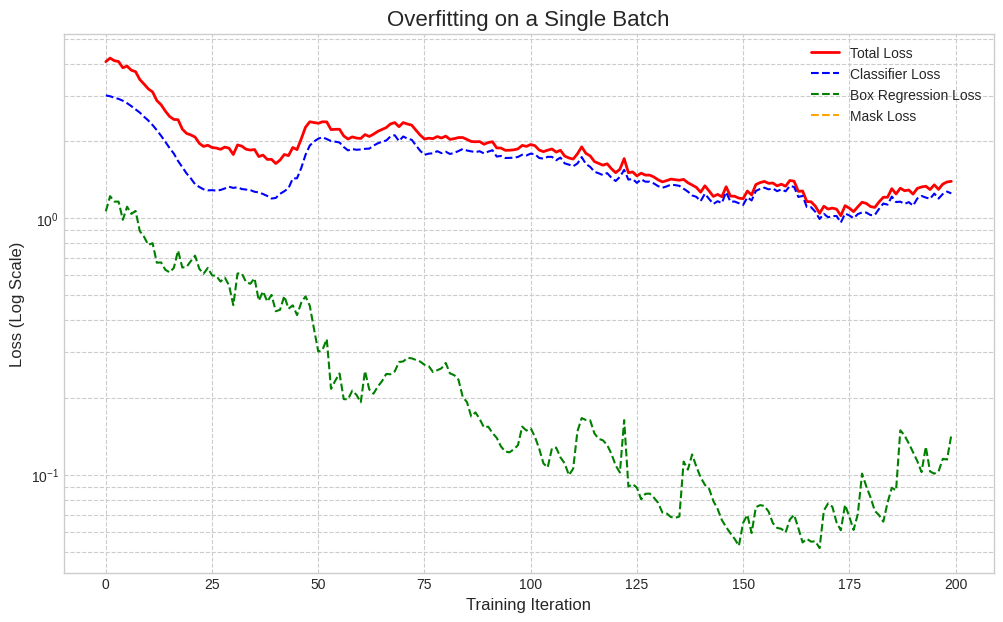

!!! DEBUGGING FINISHED. STOPPING EXECUTION. !!!


In [33]:
def main():
    from torch.optim.lr_scheduler import StepLR

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    IMAGE_SIZE = (512, 512)
    BATCH_SIZE = 4 
    LEARNING_RATE = 0.001 # Có thể tăng LR một chút để thấy loss giảm nhanh hơn khi debug
    NUM_EPOCHS = 20
    DATA_ROOT = "/kaggle/working/cityscapes"

    train_dataset = CityscapesMaskRCNNDataset(root_dir=DATA_ROOT, set_type='train', image_size=IMAGE_SIZE)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=0)

    model = MaskRCNN(num_classes=NUM_CLASSES).to(device)
    
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.SGD(params, lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0005)
    
    # --- [KÍCH HOẠT DEBUG] ---
    # Bỏ comment các dòng dưới đây để chạy chế độ debug.
    # Chương trình sẽ dừng lại sau khi chạy xong phần này.
    print("\n!!! RUNNING IN DEBUG MODE: OVERFITTING ONE BATCH & PLOTTING !!!")
    debug_and_plot_one_batch(model, train_loader, optimizer, device, num_iterations=200)
    print("!!! DEBUGGING FINISHED. STOPPING EXECUTION. !!!")
    return 
    # --- KẾT THÚC DEBUG ---

    # Các dòng code dưới đây sẽ không được chạy khi đang debug
    val_dataset = CityscapesMaskRCNNDataset(root_dir=DATA_ROOT, set_type='val', image_size=IMAGE_SIZE)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=0)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
    train(model, train_loader, val_loader, optimizer, scheduler, device, num_epochs=NUM_EPOCHS)

if __name__ == "__main__":
    # Đừng quên thêm các hàm mới vào file của bạn
    # ví dụ: plot_loss_history và phiên bản mới của debug_and_plot_one_batch
    main()

Using device: cuda
Loaded 1299 train images
Initializing weights for new layers...

!!! RUNNING IN DEBUG MODE: OVERFITTING ONE BATCH & PLOTTING !!!

--- Starting Overfitting Debug on One Batch ---
Using 4 images. Running for 200 iterations.
Step 000: Total=3.8082 (Cls=2.9080, Reg=0.9002, Mask=0.0000)
Step 010: Total=2.9586 (Cls=2.1793, Reg=0.7793, Mask=0.0000)
Step 020: Total=1.8121 (Cls=1.2055, Reg=0.6066, Mask=0.0000)
Step 030: Total=1.6584 (Cls=1.2105, Reg=0.4479, Mask=0.0000)
Step 040: Total=1.4843 (Cls=1.0942, Reg=0.3901, Mask=0.0000)
Step 050: Total=1.4081 (Cls=1.0823, Reg=0.3258, Mask=0.0000)
Step 060: Total=1.2902 (Cls=1.0685, Reg=0.2217, Mask=0.0000)
Step 070: Total=1.2498 (Cls=1.0536, Reg=0.1962, Mask=0.0000)
Step 080: Total=1.1925 (Cls=1.0164, Reg=0.1761, Mask=0.0000)
Step 090: Total=1.3002 (Cls=1.1234, Reg=0.1768, Mask=0.0000)
Step 100: Total=1.2262 (Cls=1.0661, Reg=0.1600, Mask=0.0000)
Step 110: Total=1.1474 (Cls=1.0073, Reg=0.1401, Mask=0.0000)
Step 120: Total=1.1897 (Cls

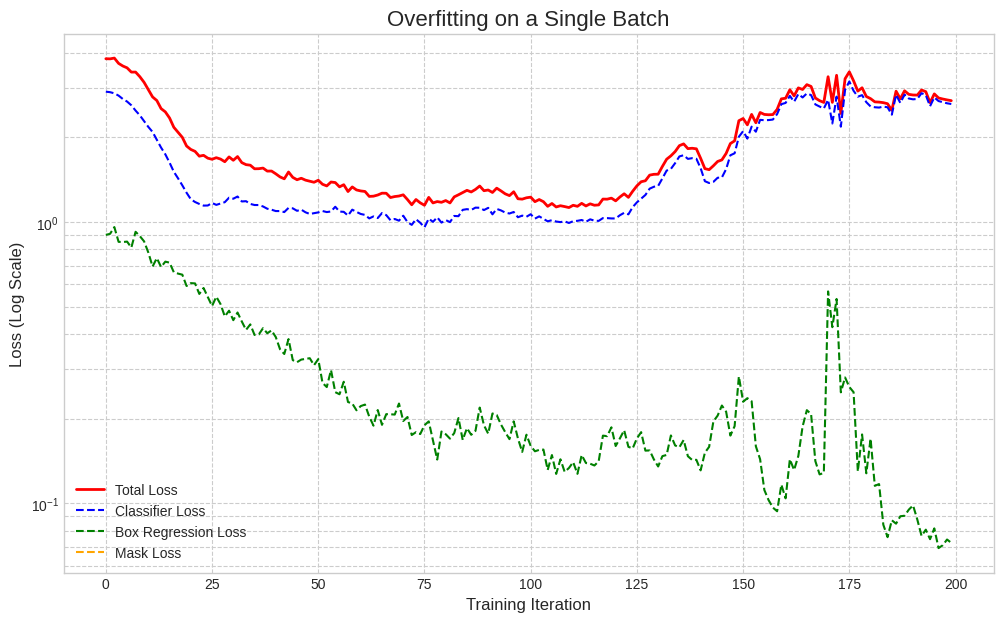

!!! DEBUGGING FINISHED. STOPPING EXECUTION. !!!


In [34]:
if __name__ == "__main__":
    main()